# センサを用いた肩関節屈曲角速度のデータ分析

## １．前準備

◼️必要モジュールのインポート：

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lpf

> `lpf`はローパスフィルタモジュール。`lpf.py`をデータおよびJupyterノートブックと同じフォルダに入れておくこと。

◼️センサデータの読み込み。読み込んだデータをデータフレーム変数`df`に格納：

In [2]:
df = pd.read_csv("memdata_TSND121-13121423_2019-05-21.csv", header=None,
                 names=['item', 't', 'acc_x', 'acc_y', 'acc_z', 'omega_x', 'omega_y', 'omega_z'])

> `"memdata_TSND121-13121423_2019-05-21.csv"`を自分のグループのデータCSVファイルに置き換えること。

◼️データフレーム`df`の確認：

In [3]:
df.head()

,item,t,acc_x,acc_y,acc_z,omega_x,omega_y,omega_z
0,ags,51000000,2508,10181,1854,557,1804,-1670
1,ags,51000001,2508,10162,1910,538,1780,-1651
2,ags,51000002,2417,10164,1839,532,1773,-1639
3,ags,51000003,2386,10142,1891,514,1755,-1615
4,ags,51000004,2376,10110,1871,490,1737,-1590


In [4]:
df.tail()

,item,t,acc_x,acc_y,acc_z,omega_x,omega_y,omega_z
68125,ags,51068125,4280,8555,2874,51,212,158
68126,ags,51068126,4383,8563,2894,45,206,140
68127,ags,51068127,4319,8570,2806,39,200,122
68128,ags,51068128,4361,8541,2850,27,200,128
68129,ags,51068129,4395,8509,2826,27,225,159


◼️データの要約統計量の確認：

## ２．データの平滑化(ノイズとバイアスの除去)

◼️データフレームから角速度のz成分を取り出し，numpy配列に変換しておく：

- `データフレーム変数['項目名']`でデータフレームの指定項目名のデータ列を取り出す。取り出したデータ列はpandasのSiriesというオブジェクト(pandas.core.series.Series)。
- 上記Siriesにnp.array関数を適用すると，Numpy配列に変換される。(1次元)Numpy配列は事実上，ベクトルとして取り扱うことができる。

In [5]:
z = np.array(df['omega_z'])/100

> 変数`z`は角速度z成分の(1次元)Numpy配列である。なお，右辺で100で割っているのは，角速度の単位を$10^{-2} \mathrm{deg/s}$を $\mathrm{deg/s}$に変更するためである。

◼️後のために，角速度z成分の要素数を数えておこう：

In [6]:
print(f'zの要素数 : {len(z)}')

zの要素数 : 68130


> 計測開始時刻0ms(0s)から68129ms(68.129s)の間の68130個の要素数（データ数）があることになる。

◼️ `z`に50Hzのローパスフィルタをかけたデータを変数`zeta0`に格納する（バイアスは除去しない）：

In [7]:
zeta0 =  lpf.lpfilter(z, 50, rmdc=False)

◼️ `z`に50Hzのローパスフィルタをかけたデータを変数`zeta`（$=\zeta$）に格納する（バイアスを除去）：

In [8]:
zeta = lpf.lpfilter(z, 50)

◼️`zeta0`と`zeta`の要素数を数えておく：

In [9]:
print(f'zeta0の要素数 : {len(zeta0)}')
print(f'zetaの要素数 : {len(zeta)}')

zeta0の要素数 : 65536
zetaの要素数 : 65536


> `zeta0`および`zeta`の要素数は，`z`の要素数より明らかに少ない。これは，ローパスフィルタプログラムの中で使っているFFT（高速フーリエ変換）のアルゴリズムに起因する。FFTは変換前のデータサンプル数が$2^n$個のとき，正確かつ高速にフーリエ変換する。従って，**`z`の要素数68130のうちの最初から$2^{16}=65536$個分だけ残し**，それ以外の要素を除去することにしているからである。

◼️計測時刻10s(10000ms)〜10.1s(10100ms)における，`z`, `zeta0`, `zeta` のそれぞれをプロットし，ノイズとバイアス除去が適切になされているか確認する：

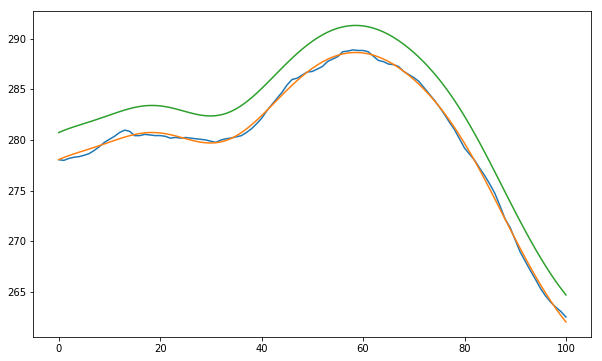

In [10]:
plt.figure(figsize=(10,6))    #グラフのサイズを10:6に設定
plt.plot(z[10000:10101])          #zを10000ms~10100msまでプロット
plt.plot(zeta0[10000:10101])   #zeta0を10000ms~10100msまでプロット
plt.plot(zeta[10000:10101])      #zetaを10000ms~10100msまでプロット
plt.show()

> 青曲線が`z`，オレンジ曲線が`zeta0`，緑曲線が`zeta`。オレンジ曲線および緑曲をみると，青曲線から綺麗にノイズが除去されているのがわかる。また緑曲線が他の曲線から上にずれているのは，バイアス（この場合負のバイアス＝要約統計量の`omega_z`の`mean`を見よ）が取り除かれているからである。

◼️平滑化された角速度のz成分$\zeta$(=`zeta`)を計測開始時刻0sから60s(60000ms)までプロットする：

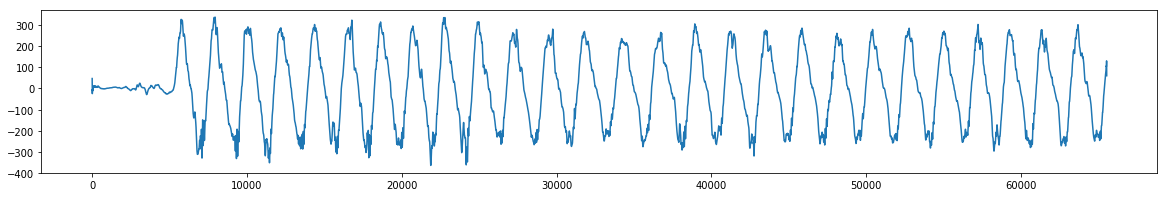

In [11]:
plt.figure(figsize=(20,3))    #グラフのサイズを20:3に設定
plt.plot(zeta)
plt.show()

> `zeta[:60001]`は`zeta[0:60001]`と同じ。`zeta`について，0ms〜60000msの60000個のデータ点をピックアップしている。

◼️ グラフをみると，$\zeta$の0秒付近で小さいがインパルス状の変動がある。後の積分のために，これを取り除いておきたい。したがって，$\zeta$について，屈曲角が0°と予測される初期時間間以内の0ms〜499msのデータを除去しておく：

In [12]:
zeta = zeta[500:]

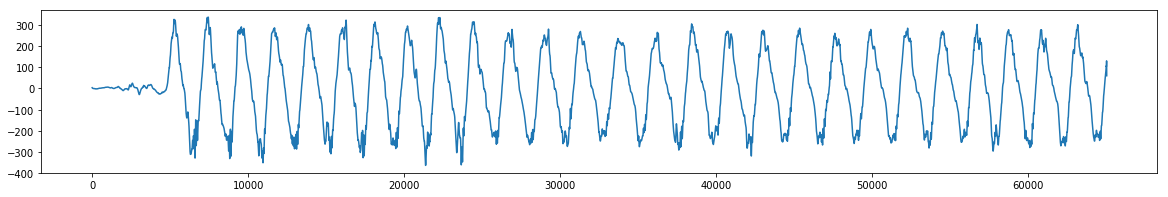

In [13]:
plt.figure(figsize=(20,3))    #グラフのサイズを20:3に設定
plt.plot(zeta)
plt.show()

## ３．角速度$\zeta$を積分することによって肩屈曲角度$\theta$を求める

◼️講義と次の図を参照して，$\zeta$(=`zeta`)を積分し，肩屈曲角$\theta$(=`theta`)を求めよ。ただし，`theta`はNumpy配列とする：

  <img src="figs/fig001.png">
<img src="figs/fig002.png">

In [14]:
s0 = 0
startpoint = 0
endpoint = 60000

s = s0
tau = 0.001
theta = [s0]

for i in range(startpoint, endpoint+1):
    s += tau * (zeta[i] + zeta[i+1]) / 2
    theta.append(s)
theta = np.array(theta)

◼️肩屈曲角$\theta$の時間的変化をプロットする。

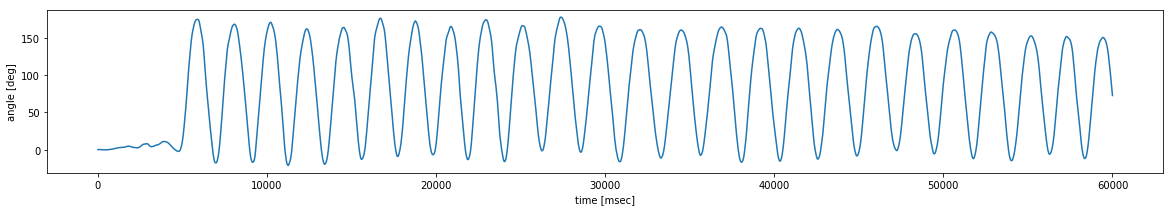

In [15]:
plt.figure(figsize=(20,3))
plt.plot(theta)
plt.xlabel('time [msec]')    #x軸ラベル
plt.ylabel('angle [deg]')        #y軸ラベル
plt.show()

◼️上記グラフから，肩屈曲角$\theta$は以下の範囲で振動する：

In [16]:
print(f'{np.max(theta)}° ≤θ≤ {np.min(theta)}°')

177.43546074764117° ≤θ≤ -21.136801773134685°


> ここで，  
> `np.min(numpy配列)` : `numpy配列`の最小の要素を返す。  
> `np.max(numpy配列)` : `numpy配列`の最大の要素を返す。  

## ４．位相空間における解析

◼️角度$\theta$と角速度$\zeta$を一つのグラフ内に表示してみよう：

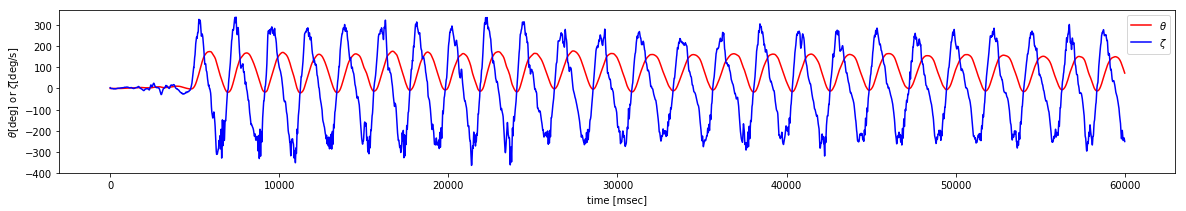

In [17]:
plt.figure(figsize=(20,3))
plt.plot(theta[:60001], c="red")
plt.plot(zeta[:60001], c="blue")
plt.legend([ f'$\\theta$', f'$\zeta$' ])
plt.xlabel('time [msec]')    #x軸ラベル
plt.ylabel(f'$\\theta$[deg] or $\zeta$[deg/s]')        #y軸ラベル
plt.show()

> 当たり前であるが，肩屈曲角$\theta$と角速度$\zeta$の周期が同じという程度のことしか判らない。

In [18]:
print(f'最小屈曲角 : {np.min(theta)} [deg]')
print(f'最大屈曲角 : {np.max(theta)} [deg]')
print(f'最小角速度 :  {np.min(zeta)} [deg/s]')
print(f'最大角速度 :  {np.max(zeta)} [deg/s]')

最小屈曲角 : -21.136801773134685 [deg]
最大屈曲角 : 177.43546074764117 [deg]
最小角速度 :  -363.9085105134261 [deg/s]
最大角速度 :  337.3178388469636 [deg/s]


◼️上のグラフは役に立たないので，**位相空間(相空間)**というものを導入する。  

通常の空間は横-縦軸に座標をとるのであるが，**位相空間**では横軸に(一般化)**座標**，縦軸に(一般化)**速度**（正確には一般化運動量）をとる。角運動については，(一般化)座標は**角度**，(一般化)速度は**角速度**になるので，今の場合の解析では，$\theta$-$\zeta$空間になる。

位相空間を用いた解析が有用になってくる運動の一つが振動である：  
1. 位相区間内の運動が楕円運動なら，安定した振動である。
2. 位相区間内の運動が**外から内に**渦を巻くなら，振動は**減衰**している。
3. 位相区間内の運動が**内から外に**渦を巻くなら，振動は**増幅**している。
4. 位相区間内の運動が揺らぎながらループを描くようなら，大きな振動のなかに小さな振動が混じっている。  
<img src="figs/phase_space.png">  


◼️横軸に$\theta$，縦軸に$\zeta$をとり位相空間内での肩屈曲角運動の軌跡を描いてみる：

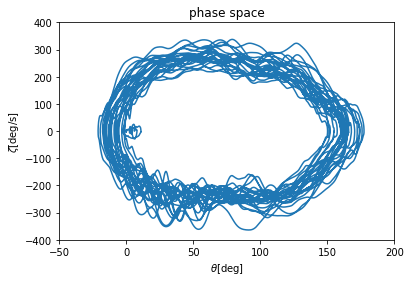

In [19]:
plt.plot(theta[:60001], zeta[:60001])   #thetaとzetaの0〜60sまでのデータ
plt.xlim((-50, 200))    #最小屈曲角，最大屈曲角からこの範囲をとった
plt.ylim((-400, 400))  #最小角速度，最大角速度からこの範囲をとった
plt.title('phase space')   #グラフタイトル
plt.xlabel(f'$\\theta$[deg]')   #横軸のラベル
plt.ylabel(f'$\zeta$[deg/s]')   #縦軸のラベル
plt.show()

> 運動は振動しながら渦を巻いているようである。しかし，上のグラフでは，渦は外から内に巻いているのかその逆なのか，あるいは全く不規則なループが重なっているのかは判別不能である。

◼️渦の巻き方が，外から内なのか，内から外なのかを判定するため，上の図で0〜30sまでの軌跡を青に，30〜60sまでの軌跡を赤にしてみる：  
※）さらに，見やすくするために，グラフを大きめの正方形に表示する。

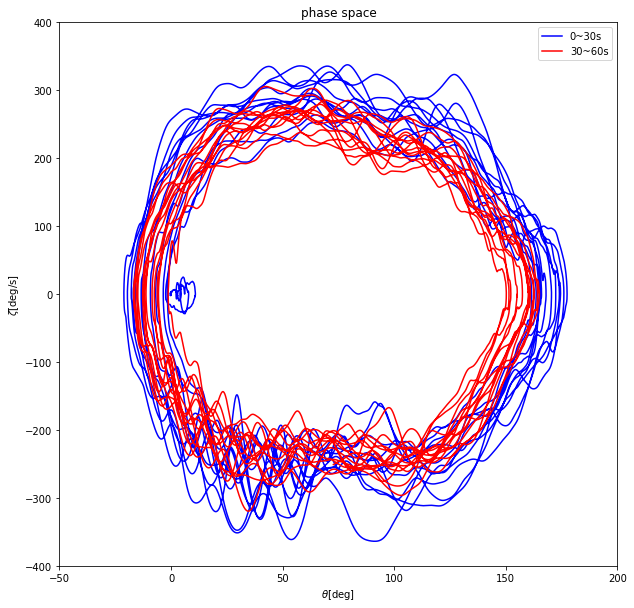

In [22]:
plt.figure(figsize=(10,10))     #グラフを大きく正方形に表示するため，figsize=(10,10)とした
plt.plot(theta[:30001], zeta[:30001], c='blue')                         #0~30sまで青
plt.plot(theta[30000:60001], zeta[30000:60001], c='red')      #30s~60sまで赤
plt.title('phase space')
plt.legend(["0~30s", "30~60s"])      #凡例の表示
plt.xlim((-50, 200))
plt.ylim((-400, 400))
plt.xlabel(f'$\\theta$[deg]')
plt.ylabel(f'$\zeta$[deg/s]')
plt.show()

> 全体として，青い(早い時刻での)軌跡が外側に，赤(遅い時刻での)軌跡が内側に位置しているので，外側から内側に向かう渦である。

◼️位相空間での分析結果からの議論  
1. １つの軌跡ループで屈曲角が最大になる角速度はどの付近か？
2. １つの軌跡ループで屈曲角が最小になる角速度はどの付近か？
3. １つの軌跡ループで角速度が最大になる屈曲角はどの付近か？
4. １つの軌跡ループで角速度が最小になる屈曲角はどの付近か？
5. 1〜4の事項は，肩屈曲角運動について何を意味するのか？
6. 角度-角速度の軌跡渦が外から内（あるいは内から外）に向かう（あるいは安定している）というのはどういう事か？
7. 軌跡ループ内の揺らぎが起こる（起こらないかもしれない）なら，そのときの角度と角速度はどの辺りか？
8. 7の事項がもし起こるなら，その事は，肩屈曲角運動に対して，何を意味するのか？
9. 7の事項が起こらないなら，その事は，肩屈曲角運動に対して，何を意味するのか？
10. 他

◼️参考

▫︎0〜30sにおける，最大の$\theta$のときの$\zeta$の値

In [30]:
zeta[ np.where( theta == np.max(theta[:30001]) )[0][0] ]

-0.18137066891067022

▫︎30〜60sにおける，最大の$\theta$のときの$\zeta$の値

In [31]:
zeta[ np.where( theta == np.max(theta[30000:60001]) )[0][0] ]

0.024959926077997352

▫︎0〜30sにおける，最大の$\zeta$のときの$\theta$の値

In [23]:
theta[ np.where( zeta == np.max(zeta[:30001]) )[0][0] ]

79.05016610585105

▫︎30〜60sにおける，最大の$\zeta$のときの$\theta$の値

In [24]:
theta[ np.where( zeta == np.max(zeta[30000:60001]) )[0][0] ]

42.54215469636456

▫︎0〜30sにおける，最小の$\zeta$のときの$\theta$の値

In [25]:
theta[ np.where( zeta == np.min(zeta[:30001]) )[0][0] ]

91.17432997990872

▫︎30〜60sにおける，最小の$\zeta$のときの$\theta$の値

In [32]:
theta[ np.where( zeta == np.min(zeta[30000:60001]) )[0][0] ]

34.55736984759029